In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial
import itertools
import os
import math
import sys
import traceback

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

parent = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent not in sys.path:
    sys.path = [parent] + sys.path
import kradagrad
from kradagrad.third_party.resnet_cifar10.trainer import model_names, train, validate, save_checkpoint, AverageMeter, accuracy
mf = kradagrad.positive_matrix_functions
import kradagrad.math_utils as mu


2023-02-02 09:21:40.396891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 09:21:41.123105: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-02 09:21:41.123195: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-02 09:21:41.123202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# build a badly conditioned, non-axis-aligned Hessian as kronecker product
#   of 2 badly conditioned, non-axis-aligned PD matrices

# reproducible
seed_problem = 4750
torch.manual_seed(seed_problem)

# problem sizes
X_sz = [128, 128]
#X_sz = [1536, 1536]

# target condition number for each factor
log_cond_num = 10
log_max_eig = 1

max_eig = 10 ** log_max_eig

sq = lambda x: -(x**8)
sqrt = lambda x: -(x**(1/8))

inv_nonlin = sqrt
nonlin = sq

# build the matrix
log_eigs = [
    (torch.linspace(0, inv_nonlin(log_cond_num), sz_, dtype=torch.float64))
    for sz_ in X_sz
]
eigs = [10 ** nonlin(r_) for r_ in log_eigs]
eigs = [eig * (max_eig/eig.max()) for eig in eigs]
Qs = [torch.linalg.qr(torch.randn(X_sz[i], X_sz[i], dtype=torch.float64))[0] for i in range(len(X_sz))]

Hs = [(Q*eig).mm(Q.T) for Q, eig in zip(Qs, eigs)]
Hs = [H_ for H_,eig in zip(Hs,eigs)]


In [3]:
# use cuda?
cuda = True

if cuda:
    Hs = [H.cuda() for H in Hs]

def loss_quad(Hs, x):
    return torch.sum(x.type_as(Hs[0]) * (Hs[0] @ x.type_as(Hs[0]) @ Hs[1])).type_as(x)

loss = lambda x: loss_quad(Hs, x)

In [4]:
Ls = [torch.linalg.eigvalsh(H) for H in Hs]
print(*[[x.cpu().numpy() for x in [L.min(), L.max(), L.max()/L.min()]] for L in Ls])

"""
plt.figure()

plt.subplot(1,3,1)
for L in Ls:
    plt.semilogy(L.cpu().numpy())
plt.title('factor eigs (log)')

if X_sz[0] < 512:
    # look ma, an approximately low-rank subspace
    total_eigs = sorted([np.prod([b.cpu() for b in a]) for a in itertools.product(*Ls)])

    plt.subplot(1,3,2)
    plt.semilogy(total_eigs)
    plt.title('total eigs (log)')

    plt.subplot(1,3,3)
    plt.plot(total_eigs)
    plt.title('total eigs (lin)')

plt.show()
"""
''

[array(1.00000114e-09), array(10.), array(9.99998864e+09)] [array(1.00000205e-09), array(10.), array(9.99997953e+09)]


''

In [5]:
"""
plt.figure()
for H in Hs:
    plt.plot(H.diag().cpu().sort()[0])
plt.title('diag values')
plt.show()
"""
''

''

In [6]:
# repeatable training run for different optimizers
def simple_train_run(X, loss_fn, n_it, opt_maker, exp_name='', dir_name = '', retain_graph=True, resets=[]):
    os.makedirs(dir_name, exist_ok=True)
    tr_fn = os.path.join(dir_name, '{}_loss_tr.npy'.format(exp_name))
    no_fn = os.path.join(dir_name, '{}_norms.npy'.format(exp_name))
    gr_fn = os.path.join(dir_name, '{}_grads.npy'.format(exp_name))
    if os.path.isfile(tr_fn):
        print('  already trained. loading: {}'.format(tr_fn))
        loss_tr = np.load(tr_fn)
        norms = np.load(no_fn) if os.path.isfile(no_fn) else []
        grads = np.load(gr_fn) if os.path.isfile(gr_fn) else []
        return loss_tr, norms, grads
    opt = opt_maker([X])
    print('  Optimizer class is actually: {}'.format(type(opt).__name__))
    norms = []
    grads = []
    loss_tr = []
    for it_ in tqdm(range(n_it), 'Epoch', ncols=80):
        err = loss_fn(X)
        if it_ in resets:
            opt = opt_maker([X])
        opt.zero_grad()
        err.backward(retain_graph=retain_graph)
        try:
            opt.step()
        except:
            print(traceback.format_exc())
            break
        try:
            norms.append([torch.sqrt((prec**2).sum()).cpu().numpy()
               for group in opt.param_groups
               for param in group['params']
               for prec in opt.state[param]['preconditioner'].preconditioners
            ])
        except:
            pass
        grads.append([torch.sqrt((param**2).sum()).detach().cpu().numpy()
           for group in opt.param_groups
           for param in group['params']
        ])
        loss_tr.append(err.item())
        
    np.save(tr_fn, loss_tr)
    if grads is not []:
        np.save(gr_fn, grads)
    if norms is not []:
        np.save(no_fn, norms)
    return loss_tr, norms, grads

In [43]:
lr_sham = 1e-2  # double at size 1536
lr_sham = 5e-3  # single and shampp (single might even still fail)
#lr_sham = 1e-3

lr_sham_hm = 5e-3

lr_krad = 5e-3  # krad

lr_krad = 5e-3 # 128

#lr_krad = 1e-3  # kradakry
#lr_krad = 1e-2  # kradapoo
lr_kradmm = 1e-2
lr_sgd = 1e-3
lr_ada = 5e0  # too high
lr_ada = 1e0

eps_sham = 1e-8
eps_krad = 1e-8
eps_kradmm = 1e-8
eps_adam = 1e-8

eps_sham_hm = 1e-8



low_rank = 0


doubles_sham = (True, False)
double_krad = False
double_rad = True
kry_dubs = (True, False)

bl_sz = max(X_sz)+1

# precon only
be = 1
stat_freq = 1
freq = 3  #compute preconditioner
#start = 5
start = 3
#start = 1


#iterative = True
iterative = False

# krad only
#bf16 = True
bf16 = False

exp_name = 'freq{:d}_start{:d}'.format(freq, start)
print('Experiment name: {}'.format(exp_name))

# training settings
n_it = 250


opt_names = ['shampoo_iterative{:d}_lr{}_eps{}_double{:d}'.format(iterative, lr_sham, eps_sham, dbl) for dbl in doubles_sham]
hps = [kradagrad.HyperParams(block_size=bl_sz, matrix_eps=eps_sham, graft_type=0, beta2=be,
    preconditioning_compute_steps=freq,
    start_preconditioning_step=start,
    iterative_matrix_roots=iterative, double=dbl,)                  # Shampoo
    for dbl in doubles_sham
]
opts = [(partial(kradagrad.Shampoo, lr=lr_sham, hyperparams=hp_)) for hp_ in hps]


# Shampp might require double for numerics too (riccati is easier than roots, but shampp takes roots too)
opt_names = opt_names + ['shampp_lr{}_eps{}_double{:d}_rank{:d}'.format(lr_sham, eps_sham, dbl, low_rank) for dbl in (True, False)]
hps = [kradagrad.HyperParams(block_size=bl_sz, matrix_eps=eps_sham, graft_type=0, beta2=be,
    preconditioning_compute_steps=freq,
    start_preconditioning_step=start,
    iterative_matrix_roots=iterative, double=dbl, low_rank=low_rank, rank_inc=1)                  # Shampp
   for dbl in (True, False)
]
opts = opts + [(lambda params: kradagrad.Shampp(params, lr=lr_sham, hyperparams=hp_)) for hp_ in hps]


# fail:
#opt_names = opt_names + ['rad_iterative{:d}_lr{}_eps{}_double{:d}'.format(iterative, lr_krad, eps_krad, double_rad)]
#hps = [kradagrad.HyperParams(block_size=bl_sz, matrix_eps=eps_krad, graft_type=0, beta2=be,
#    preconditioning_compute_steps=freq,
#    start_preconditioning_step=start,
#    statistics_compute_steps=stat_freq,
#    bf16=bf16, double=double_rad,
#    iterative_matrix_roots=iterative, low_rank=25)]                                # Rad
#opts = opts + [partial(kradagrad.Radagrad, lr=lr_krad, hyperparams=hp_, debug=True) for hp_ in hps]




#opt_names = opt_names + ['shampoohm_iterative{:d}_lr{}_eps{}_double{:d}'.format(iterative, lr_sham_hm, eps_sham_hm, dub_sham_) for dub_sham_ in doubles_sham]
#hps = [kradagrad.HyperParams(block_size=bl_sz, matrix_eps=eps_sham_hm, graft_type=0, beta2=be,
#    preconditioning_compute_steps=freq,
#    start_preconditioning_step=start,
#    statistics_compute_steps=stat_freq,
#    bf16=bf16, double=dub_sham_,
#    iterative_matrix_roots=iterative) for dub_sham_ in doubles_sham]  # shampoo using harmonic mean
#opts = opts + [partial(kradagrad.ShampooHM, lr=lr_sham_hm, hyperparams=hp_, debug=True) for hp_ in hps]



#opt_names = opt_names + ['kradmm_lr{}_eps{}'.format(lr_kradmm, eps_krad)]
#hps = [kradagrad.HyperParams(block_size=bl_sz, matrix_eps=eps_krad, graft_type=0, beta2=be,
#    preconditioning_compute_steps=freq,
#    start_preconditioning_step=start,
#    bf16=False,
#    iterative_matrix_roots=False)]                                # Krad--
#opts = opts + [(lambda params: kradagrad.KradagradMM(params, lr=lr_kradmm, hyperparams=hp_)) for hp_ in hps]




# opt_names = opt_names + ['kradakry_iterative{:d}_lr{}_eps{}_qr{:d}_double{:d}'.format(iterative, lr_krad, eps_krad, True, kry_dub_) for kry_dub_ in kry_dubs]
# hps = [kradagrad.HyperParams(block_size=bl_sz, matrix_eps=eps_krad, graft_type=0, beta2=be,
#     preconditioning_compute_steps=freq,
#     start_preconditioning_step=start,
#     statistics_compute_steps=stat_freq,
#     bf16=bf16, kry_qr=True, double=kry_dub_,
#     iterative_matrix_roots=iterative) for kry_dub_ in kry_dubs]          # Kry
# opts = opts + [partial(kradagrad.KradaKry, lr=lr_krad, hyperparams=hp_, debug=True) for hp_ in hps]
# 
# opt_names = opt_names + ['krypoo_iterative{:d}_lr{}_eps{}_qr{:d}_double{:d}'.format(iterative, lr_krad, eps_krad, True, kry_dub_) for kry_dub_ in kry_dubs]
# hps = [kradagrad.HyperParams(block_size=bl_sz, matrix_eps=eps_krad, graft_type=0, beta2=be,
#     preconditioning_compute_steps=freq,
#     start_preconditioning_step=start,
#     statistics_compute_steps=stat_freq,
#     bf16=bf16, kry_qr=True, double=kry_dub_,
#     iterative_matrix_roots=iterative) for kry_dub_ in kry_dubs]          # Krypoo
# opts = opts + [partial(kradagrad.KradaKrypoo, lr=lr_krad, hyperparams=hp_, debug=True) for hp_ in hps]

opt_names = opt_names + ['krad_iterative{:d}_lr{}_eps{}_double{:d}'.format(iterative, lr_krad, eps_krad, double_krad)]
hps = [kradagrad.HyperParams(block_size=bl_sz, matrix_eps=eps_krad, graft_type=0, beta2=be,
    preconditioning_compute_steps=freq,
    start_preconditioning_step=start,
    statistics_compute_steps=stat_freq,
    bf16=bf16, double=double_krad,
    iterative_matrix_roots=iterative)]                                # Krad
opts = opts + [partial(kradagrad.KradagradPP, lr=lr_krad, hyperparams=hp_, debug=True) for hp_ in hps]

#opt_names = opt_names + ['kradelay_lr{}_eps{}_double{:d}_bf16{:d}'.format(lr_krad, eps_krad, True, False)]
#hps = [kradagrad.HyperParams(block_size=bl_sz, matrix_eps=eps_krad, graft_type=0, beta2=be,
#    preconditioning_compute_steps=freq,
#    start_preconditioning_step=start,
#    statistics_compute_steps=stat_freq, double=True,
#    bf16=False)]                                                         # Kradelay
#opts = opts + [partial(kradagrad.Kradelay, lr=lr_krad, hyperparams=hp_) for hp_ in hps]

#kradapoo_types = (0,1,)
#opt_names = opt_names + ['kradapoo_lr{}_eps{}_type{}'.format(lr_krad, eps_krad, kpt_) for kpt_ in kradapoo_types]
#hps = [kradagrad.HyperParams(block_size=bl_sz, matrix_eps=eps_krad, graft_type=0, beta2=be,
#    preconditioning_compute_steps=freq,
#    start_preconditioning_step=start,
#    statistics_compute_steps=stat_freq,
#    bf16=False,
#    kradapoo_type=kpt_) for kpt_ in kradapoo_types]                         # Kradapoo
#opts = opts + [partial(kradagrad.Kradapoo, lr=lr_krad, hyperparams=hp_) for hp_ in hps]

opt_names = opt_names + ['adam_lr{}_eps{}'.format(lr_ada, eps_adam)]  # Adam
opts = opts + [partial(torch.optim.Adam, lr=lr_ada, eps=eps_adam)]


opt_names = opt_names + ['sgd_lr{}'.format(lr_sgd)]                   # sgd
opts = opts + [partial(torch.optim.SGD, lr=lr_sgd)]


seed_exp = 95054
dir_name = 'quad_out_size{}_logcond{}_logmaxeig{}'.format(X_sz[0], log_cond_num, log_max_eig)
loss_tr = {}
norms = {}
grads = {}
for opt_name_, opt_ in zip(opt_names, opts):
    print('Using {}'.format(opt_name_))
    exp_name_ = exp_name
    torch.manual_seed(seed_exp)
    # create init
    X = torch.randn(X_sz, requires_grad=True, device='cuda' if cuda else 'cpu')
    #X = torch.ones(X_sz, requires_grad=True)
    if cuda:
        exp_name_ = '{}_cuda'.format(exp_name_)
    exp_name_ = '{}_{}'.format(opt_name_, exp_name_)

    # `retain_graph` still required for some reason... haven't figured out why
    try:
        torch.autograd.set_detect_anomaly(False)
        loss_tr_, norms_, grads_ = simple_train_run(
            X, loss, n_it, opt_, exp_name=exp_name_, dir_name=dir_name,
            #resets=[50, 100, 150, 200] if ('krad' in opt_name_ or 'sham' in opt_name_) else []
        )
        loss_tr[opt_name_] = loss_tr_
        norms[opt_name_] = norms_
        grads[opt_name_] = grads_
    except Exception as err:
        print(traceback.format_exc())


Experiment name: freq3_start3
Using shampoo_iterative0_lr0.005_eps1e-08_double1
  already trained. loading: quad_out_size128_logcond10_logmaxeig1/shampoo_iterative0_lr0.005_eps1e-08_double1_freq3_start3_cuda_loss_tr.npy
Using shampoo_iterative0_lr0.005_eps1e-08_double0
  already trained. loading: quad_out_size128_logcond10_logmaxeig1/shampoo_iterative0_lr0.005_eps1e-08_double0_freq3_start3_cuda_loss_tr.npy
Using shampp_lr0.005_eps1e-08_double1_rank0
  already trained. loading: quad_out_size128_logcond10_logmaxeig1/shampp_lr0.005_eps1e-08_double1_rank0_freq3_start3_cuda_loss_tr.npy
Using shampp_lr0.005_eps1e-08_double0_rank0
  already trained. loading: quad_out_size128_logcond10_logmaxeig1/shampp_lr0.005_eps1e-08_double0_rank0_freq3_start3_cuda_loss_tr.npy
Using krad_iterative0_lr0.005_eps1e-08_double0
  already trained. loading: quad_out_size128_logcond10_logmaxeig1/krad_iterative0_lr0.005_eps1e-08_double0_freq3_start3_cuda_loss_tr.npy
Using adam_lr1.0_eps1e-08
  already trained. loadi

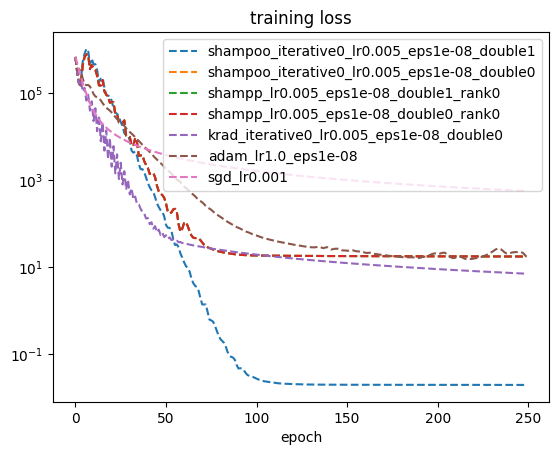

In [42]:
# plot
skips = ['kradmm', 'kradapoo', 'kradelay', 'kradakry']

plt.figure()
valids = []
for opt_name_ in opt_names:
    if any([x in opt_name_ for x in skips]):
        continue
    try:
        plt.semilogy(range(min(n_it, len(loss_tr[opt_name_]))), loss_tr[opt_name_], '--')
        valids.append(opt_name_)
    except:
        pass
plt.legend(valids)
plt.xlabel('epoch')
plt.title('training loss')

plt.show()

## diagnostics

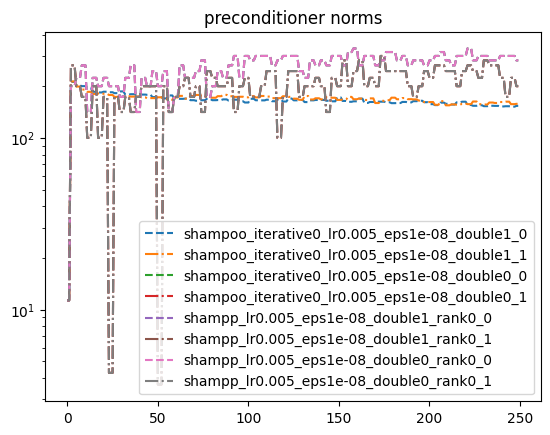

In [36]:
flatten = lambda z: [x for y in z for x in y]

skips = ['kradmm', 'kradapoo']

view_only =['kry', 'shampoo', 'shampp']

plt.figure()
used_names = []
for opt_ in norms.keys():
    if any([x in opt_ for x in skips])or not any([x in opt_ for x in view_only]):
        continue
    if np.array(norms[opt_]).size <= 0:
        break
    plt.semilogy(np.array(norms[opt_])[:, 0], '--')
    plt.semilogy(np.array(norms[opt_])[:, 1], '-.')
    used_names.append(opt_)
plt.legend(flatten([
    ('{}_0'.format(opt_), '{}_1'.format(opt_)) for opt_ in used_names
]))
plt.title('preconditioner norms')
plt.show()

In [57]:
#norms['kradapoo_lr0.005_eps1e-08_type1']

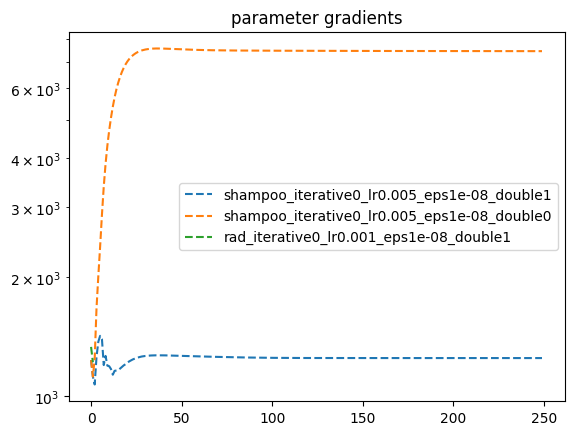

In [121]:

skips = ['kradmm', 'kradapoo', 'shampp', 'sgd', 'adam']


used_names = []
plt.figure()
for opt_ in grads.keys():
    if any([x in opt_ for x in skips]):
        continue
    if np.array(grads[opt_]).size <= 0:
        break
    plt.semilogy(np.array(grads[opt_])[:, 0], '--')
    used_names.append(opt_)

plt.legend(used_names)
plt.title('parameter gradients')
plt.show()

['shampoo_iterative0_lr0.005_eps1e-08_double1', 'shampp_lr0.005_eps1e-08_double1_rank0', 'adam_lr1.0_eps1e-08']


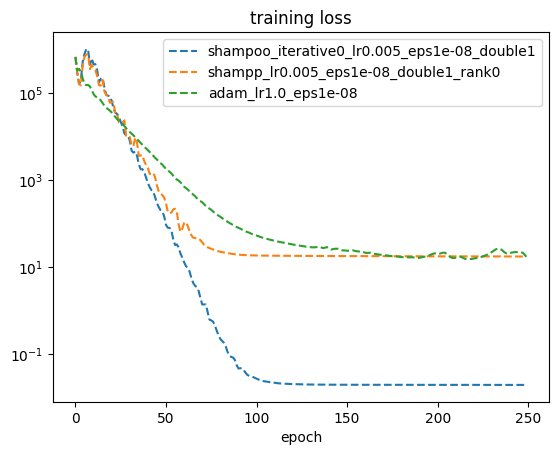

In [37]:
# select specific ones to compare
compare_names = [
    'shampoo',
    'shampp',
    #'shampp',
    #'krad_',
    #'kradelay',
    #'kradmm',
    #'type1',
    'adam',
    #'sgd'
]

compare_names_full = [
    [key for key in loss_tr.keys() if name_ in key][0]
    for name_ in compare_names
]
print(compare_names_full)

plt.figure()
for opt_name_ in compare_names_full:
    plt.semilogy(range(len(loss_tr[opt_name_])), loss_tr[opt_name_], '--')
plt.legend(compare_names_full)
#plt.ylim([5e-5,1e-3])
plt.xlabel('epoch')
plt.title('training loss')

plt.show()

In [20]:
np.array(loss_tr['shampp_lr0.005_eps1e-08_double1_replace1'])

array([9.53885760e+07, 4.14451440e+07, 2.30285920e+07, 3.93149000e+07,
       1.17710328e+08, 2.49720816e+08, 5.52949248e+08, 1.20499443e+09,
       2.70374579e+09, 5.96692992e+09, 1.28213627e+10, 2.80409907e+10,
       6.27442934e+10, 1.37101754e+11, 3.01523862e+11, 6.70390485e+11,
       1.50182429e+12, 3.26165856e+12, 7.11653537e+12, 1.57744617e+13,
       3.43559677e+13, 7.67637408e+13, 1.69558850e+14, 3.80318045e+14,
       8.47423153e+14, 1.85055444e+15, 4.07543622e+15, 9.02325921e+15,
       1.98803256e+16, 4.44901618e+16, 9.63212988e+16, 2.09237355e+17,
       4.67381296e+17, 1.05488115e+18, 2.27598907e+18, 5.01541349e+18,
       1.09737814e+19, 2.42191757e+19, 5.31021719e+19, 1.18071399e+20,
       2.59510376e+20, 5.70029366e+20, 1.24416387e+21, 2.75940531e+21,
       6.04944669e+21, 1.25069758e+22, 2.36386446e+22, 4.21326922e+22,
       4.45961207e+22, 3.53373481e+22, 2.99859819e+22, 2.38470554e+22,
       1.99568934e+22, 1.60613833e+22, 1.32642617e+22, 1.07854793e+22,
      